In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.FashionMNIST('/F_MNIST_data', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

testset = datasets.FashionMNIST('/F_MNIST_data', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

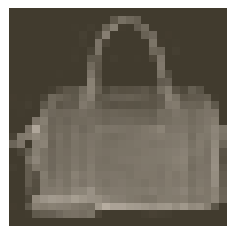

In [8]:
image, label = next(iter(trainloader))
helper.imshow(image[0, :])

In [15]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p = 0.5):
        super().__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p = drop_p)
        
    def forward(self, x):
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim = 1)

In [16]:
model = Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [31]:
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        output = model(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()
        
    return test_loss, accuracy

In [27]:
def train(model, trainloader, testloader, criterion, optimizer, epochs = 5, print_every = 40):
    steps = 0
    train_loss = 0
    for e in range(epochs):
        model.train()
        for images, labels in trainloader:
            steps += 1
            images.resize_(images.shape[0], 784)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if steps % print_every == 0:
                model.eval()
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print('Epoch {}/{}..'.format(e+1, epochs),
                     'Training Loss: {:.3f}..'.format(train_loss/print_every),
                     'Test Loss: {:.3f}..'.format(test_loss/len(testloader)),
                     'Test Accuracy: {:.3f}..'.format(accuracy/len(testloader)))
                
                train_loss = 0
                
                model.train()

In [32]:
train(model, trainloader, testloader, criterion, optimizer, epochs = 2)

Epoch 1/2.. Training Loss: 0.894.. Test Loss: 0.710.. Test Accuracy: 0.731..
Epoch 1/2.. Training Loss: 0.833.. Test Loss: 0.698.. Test Accuracy: 0.735..
Epoch 1/2.. Training Loss: 0.792.. Test Loss: 0.629.. Test Accuracy: 0.766..
Epoch 1/2.. Training Loss: 0.763.. Test Loss: 0.621.. Test Accuracy: 0.765..
Epoch 1/2.. Training Loss: 0.775.. Test Loss: 0.655.. Test Accuracy: 0.758..
Epoch 1/2.. Training Loss: 0.809.. Test Loss: 0.613.. Test Accuracy: 0.775..
Epoch 1/2.. Training Loss: 0.801.. Test Loss: 0.631.. Test Accuracy: 0.777..
Epoch 1/2.. Training Loss: 0.756.. Test Loss: 0.602.. Test Accuracy: 0.776..
Epoch 1/2.. Training Loss: 0.767.. Test Loss: 0.660.. Test Accuracy: 0.774..
Epoch 1/2.. Training Loss: 0.777.. Test Loss: 0.575.. Test Accuracy: 0.789..
Epoch 1/2.. Training Loss: 0.783.. Test Loss: 0.558.. Test Accuracy: 0.808..
Epoch 1/2.. Training Loss: 0.764.. Test Loss: 0.573.. Test Accuracy: 0.803..
Epoch 1/2.. Training Loss: 0.769.. Test Loss: 0.636.. Test Accuracy: 0.783..

# Saving and Loading Networks

In [33]:
print('Our model: \n\n', model, '\n')
print('The state dict keys: \n\n', model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [34]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [37]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [38]:
model.load_state_dict(state_dict)

In [40]:
model2 = Network(784, 10, [400, 200, 100])
model2.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param of torch.Size([400, 784]) from checkpoint, where the shape is torch.Size([512, 784]) in current model.
	size mismatch for hidden_layers.0.bias: copying a param of torch.Size([400]) from checkpoint, where the shape is torch.Size([512]) in current model.
	size mismatch for hidden_layers.1.weight: copying a param of torch.Size([200, 400]) from checkpoint, where the shape is torch.Size([256, 512]) in current model.
	size mismatch for hidden_layers.1.bias: copying a param of torch.Size([200]) from checkpoint, where the shape is torch.Size([256]) in current model.
	size mismatch for hidden_layers.2.weight: copying a param of torch.Size([100, 200]) from checkpoint, where the shape is torch.Size([128, 256]) in current model.
	size mismatch for hidden_layers.2.bias: copying a param of torch.Size([100]) from checkpoint, where the shape is torch.Size([128]) in current model.
	size mismatch for output.weight: copying a param of torch.Size([10, 100]) from checkpoint, where the shape is torch.Size([10, 128]) in current model.

In [44]:
checkpoint = {'input_size': 784,
             'output_size': 10,
             'hidden_layers': [each.out_features for each in model.hidden_layers],
             'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [45]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                   checkpoint['output_size'],
                   checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [46]:
model = load_checkpoint('checkpoint.pth')

In [47]:
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)
